In [1]:
import pandas as pd
import os
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sklearn


## Working on prepared Dataset

In [2]:
# Read dataset__lcz.csv
df = pd.read_csv('dataset_after_feature_engineering.csv')
df.head()

,sensor,DateTime,PM25,temperature,precipitation,humidity,cloudiness,pressure,temperature1,humidity1,...,date,Wx,Wy,max Wx,max Wy,timestamp_s,Day sin,Day cos,Year sin,Year cos
0,5,2021-01-01 00:00:00,61.3,-13,0,98,3,10057,10,91,...,2021-01-01,-15.320889,-12.855752,-22.981333,-19.283628,1.609459e+09,-6.012051e-12,1.000000,0.010881,0.999941
1,5,2021-01-01 01:00:00,319.9,-18,0,98,5,10060,10,91,...,2021-01-01,-28.190779,-10.260604,-28.190779,-10.260604,1.609463e+09,2.588190e-01,0.965926,0.011597,0.999933
2,5,2021-01-01 02:00:00,121.3,-12,0,98,2,10062,0,91,...,2021-01-01,-17.320508,-10.000000,-25.980762,-15.000000,1.609466e+09,5.000000e-01,0.866025,0.012314,0.999924
3,5,2021-01-01 03:00:00,119.0,-6,0,98,8,10060,0,91,...,2021-01-01,-22.981333,-19.283628,-22.981333,-19.283628,1.609470e+09,7.071068e-01,0.707107,0.013031,0.999915
4,5,2021-01-01 04:00:00,139.1,2,0,98,8,10061,0,91,...,2021-01-01,-17.320508,-10.000000,-25.980762,-15.000000,1.609474e+09,8.660254e-01,0.500000,0.013747,0.999905


In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

sensor           0
DateTime         0
PM25             0
temperature      0
precipitation    0
humidity         0
cloudiness       0
pressure         0
temperature1     0
humidity1        0
lcz              0
1                0
2                0
3                0
4                0
5                0
6                0
8                0
9                0
10               0
A                0
B                0
D                0
E                0
F                0
G                0
traffic          0
date             0
Wx               0
Wy               0
max Wx           0
max Wy           0
timestamp_s      0
Day sin          0
Day cos          0
Year sin         0
Year cos         0
dtype: int64


In [4]:
# Check for NaN values
nan_values = df.isna().sum()
print(nan_values)


sensor           0
DateTime         0
PM25             0
temperature      0
precipitation    0
humidity         0
cloudiness       0
pressure         0
temperature1     0
humidity1        0
lcz              0
1                0
2                0
3                0
4                0
5                0
6                0
8                0
9                0
10               0
A                0
B                0
D                0
E                0
F                0
G                0
traffic          0
date             0
Wx               0
Wy               0
max Wx           0
max Wy           0
timestamp_s      0
Day sin          0
Day cos          0
Year sin         0
Year cos         0
dtype: int64


## XGBoost model

In [6]:
column_list = list(df.columns)  # Convert the columns attribute to a list

print(column_list)  # Print the list of column names

['sensor', 'DateTime', 'PM25', 'temperature', 'precipitation', 'humidity', 'cloudiness', 'pressure', 'temperature1', 'humidity1', 'lcz', '1', '2', '3', '4', '5', '6', '8', '9', '10', 'A', 'B', 'D', 'E', 'F', 'G', 'traffic', 'date', 'Wx', 'Wy', 'max Wx', 'max Wy', 'timestamp_s', 'Day sin', 'Day cos', 'Year sin', 'Year cos']


In [4]:
# Define the features to use for training
features = ['temperature', 'precipitation', 'humidity', 'cloudiness', 'pressure','temperature1', 'humidity1',
            'Wx', 'Wy', 'max Wx', 'max Wy',
            'lcz', '1', '2', '3', '4', '5', '6', '8', '9','10', 'A', 'B', 'D', 'E', 'F', 'G',
            'traffic',  
            'Day sin', 'Day cos', 'Year sin', 'Year cos']

In [22]:
import pandas as pd

# Assuming your date column is already in datetime format
df['date'] = pd.to_datetime(df['date'])

cut_line = pd.to_datetime('2022-11-01')

training_mask = df['date'] < cut_line
test_mask = (df['date'] >= cut_line) & (df['date'] <= '2022-12-31')

train_df = df[training_mask]
print(f"Number of train records: {train_df.shape[0]}")

test_df = df[test_mask]
print(f"Number of test records: {test_df.shape[0]}")

Number of train records: 339690
Number of test records: 33578


In [23]:
from sklearn.model_selection import train_test_split

# Split the data into input (X) and output (y) arrays
X = train_df[features].values
y = train_df['PM25'].values

# Split the data into training and test sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


X_test = test_df[features].values
y_test = test_df['PM25'].values


In [27]:
from sklearn.model_selection import train_test_split

# Split the data into input (X) and output (y) arrays
X = df[features].values
y = df['PM25'].values

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2/0.9, random_state=42)

In [28]:
#Normalize the data

train_mean = X_train.mean()
train_std = X_train.std()

X_train = (X_train - train_mean) / train_std
X_valid = (X_valid - train_mean) / train_std
X_test = (X_test - train_mean) / train_std



In [16]:
unique_values = df['lcz'].unique()
print(unique_values)


[ 5  6  4  2  9 12 10 14 15]


In [12]:
result = (unique_values - train_mean) / train_std
print(result)

[-0.18508207 -0.18451601 -0.18564813 -0.18678026 -0.18281781 -0.18111962
 -0.18225175 -0.1799875  -0.17942143]


In [ ]:
'class'

In [27]:
import pandas as pd

# Convert X_train array to DataFrame
X_train_df = pd.DataFrame(X_train, columns=features)

# Check the head of X_train
print(X_train_df.head())


   temperature  precipitation  humidity  cloudiness  pressure  temperature1  \
0    -0.096373      -0.188053 -0.139383   -0.185789  5.580944     -0.046572   
1    -0.099769      -0.188053 -0.143911   -0.183525  5.502847     -0.114483   
2    -0.120708      -0.188053 -0.137686   -0.183525  5.513034     -0.097505   
3    -0.159191      -0.188618 -0.137120   -0.183525  5.516429     -0.142779   
4    -0.108258      -0.188053 -0.160888   -0.183525  5.460969     -0.080528   

   humidity1        Wx        Wy    max Wx  ...         B         D         E  \
0  -0.150136 -0.199371 -0.188053 -0.216349  ... -0.188053 -0.188053 -0.188053   
1  -0.135422 -0.212558 -0.202201 -0.237063  ... -0.188053 -0.188053 -0.188053   
2  -0.132026 -0.221492 -0.182156 -0.238212  ... -0.188053 -0.188053 -0.188053   
3  -0.132592 -0.204772 -0.185104 -0.254931  ... -0.188053 -0.188053 -0.188053   
4  -0.154097 -0.246255 -0.257416 -0.246255  ... -0.188053 -0.188053 -0.188053   

          F         G   traffic   Day 

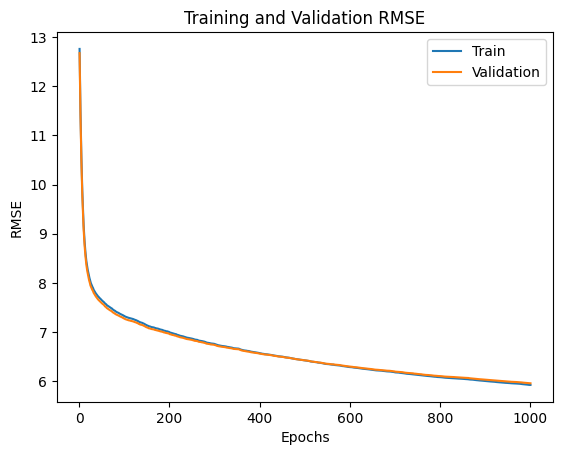

In [26]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Define the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, max_depth=3, learning_rate=0.1, early_stopping_rounds=250)

# Train the model and monitor performance on the validation set
eval_set = [(X_train, y_train), (X_valid, y_valid)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# Get the evaluation results
results = model.evals_result()

# Extract the training and validation metrics
train_metrics = results['validation_0']['rmse']
valid_metrics = results['validation_1']['rmse']

# Plot the training and validation metrics
epochs = range(1, len(train_metrics) + 1)
plt.plot(epochs, train_metrics, label='Train')
plt.plot(epochs, valid_metrics, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.show()

In [43]:
# Save the model
model.save_model('xgb_model.model')

In [9]:
# Load the saved model
import xgboost as xgb
model = xgb.XGBRegressor()
model.load_model('xgb_model.model')

In [211]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Define the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Retrain the model with the best hyperparameters on the full training set
best_model.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [214]:
print(grid_search.best_params_)

{'learning_rate': 0.1, 'max_depth': 3}


In [18]:
# Get the best iteration/epoch
best_iteration = model.best_iteration

print(model.best_iteration)

999


In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate the model on the validation set
val_preds = model.predict(X_valid)
val_rmse = np.sqrt(mean_squared_error(y_valid, val_preds))
val_mae = mean_absolute_error(y_valid, val_preds)

print("Validation RMSE: {:.2f}".format(val_rmse))
print("Validation MAE: {:.2f}".format(val_mae))

# Calculate R2 for validation sets
val_r2 = r2_score(y_valid, val_preds)
print("Validation R2: {:.2f}".format(val_r2))


Validation RMSE: 5.94
Validation MAE: 3.84
Validation R2: 0.57


In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate the model on the test set
test_preds = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
test_mae = mean_absolute_error(y_test, test_preds)

print("Test RMSE: {:.2f}".format(test_rmse))
print("Test MAE: {:.2f}".format(test_mae))

# Calculate R2 for test sets
test_r2 = r2_score(y_test, test_preds)
print("Test R2: {:.2f}".format(test_r2))


Test RMSE: 5.87
Test MAE: 3.80
Test R2: 0.58


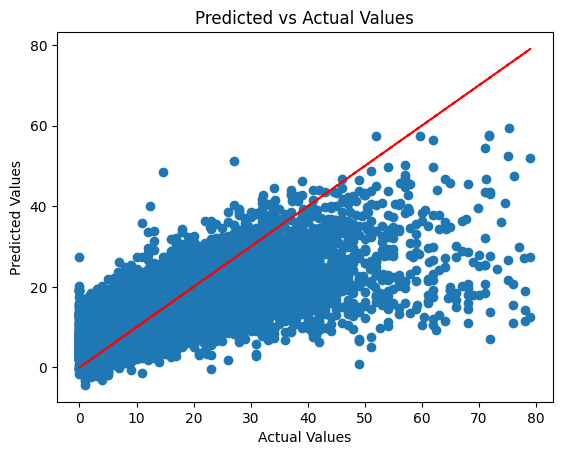

In [29]:
#Visualize predicted values agains the actual values
import matplotlib.pyplot as plt

plt.scatter(y_test, test_preds)
plt.plot(y_test, y_test, 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()


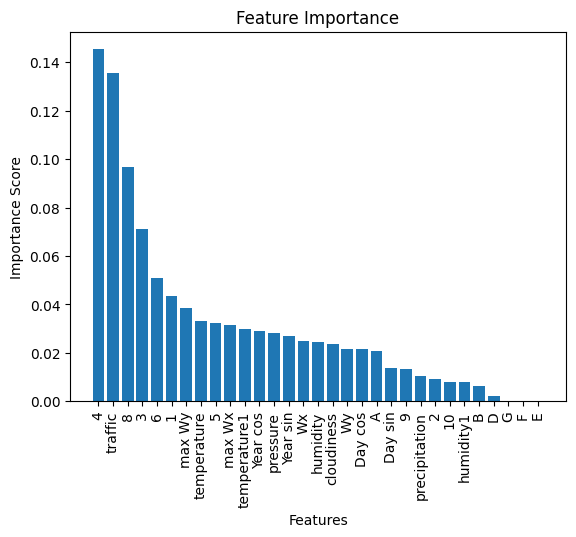

None


In [35]:
import pandas as pd

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]


plt.bar(range(len(features)), importances[indices])
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Feature Importance")
plt.show()

feature_scores = pd.DataFrame({'Variable': [features[i] for i in indices], 'Importance Score': importances[indices]})

print(feature_scores.to_csv('feature_scores.csv', index=False))

In [162]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
print("Cross-Validation RMSE: {:.2f} (+/- {:.2f})".format(rmse_scores.mean(), rmse_scores.std()))


Cross-Validation RMSE: 12.49 (+/- 2.61)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

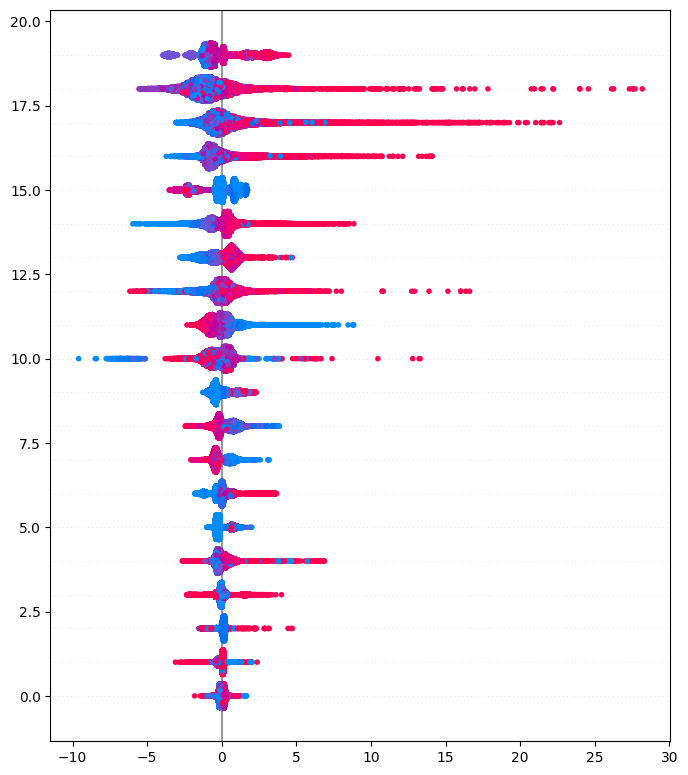

In [51]:
#using SHAP with XGBoost model
import shap

# Create an explainer object using the trained XGBoost model and the background dataset
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)

# Visualize the summary plot of feature importances
shap.summary_plot(shap_values, X_test, plot_type='dot', show=False)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the summary plot
shap.summary_plot(shap_values, X_test, plot_type='dot', color_bar=False, ax=ax, show=False)

# Add a legend
plt.legend(loc='upper right')

# Show the plot
plt.show()

In [111]:
# Convert X_test to a DataFrame
X_test_df = pd.DataFrame(X_test)

# Initialize JavaScript for SHAP plots
shap.initjs()

# Explain an individual prediction
shap.force_plot(explainer.expected_value, shap_values[0], X_test_df.iloc[0])



In [112]:
# Convert X_test to a DataFrame
X_test_df = pd.DataFrame(X_test)

# Initialize JavaScript for SHAP plots
shap.initjs()

# Explain an individual prediction
shap.force_plot(explainer.expected_value, shap_values[:10], X_test_df[:10])


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


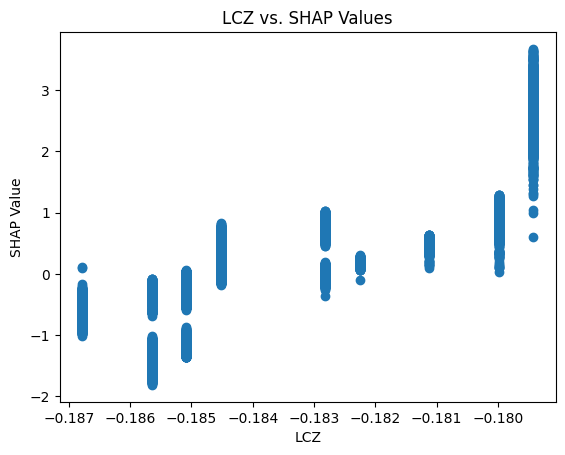

In [52]:
#compute and visualize the SHAP values for the LCZ classes
import shap

# Create an explainer object using the trained XGBoost model and the background dataset
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)

# Get the index of the 'lcz' feature in the list of features
lcz_index = features.index('lcz')

# Get the SHAP values for the 'lcz' feature
lcz_shap_values = shap_values[:, lcz_index]

# Visualize the scatter plot of 'lcz' feature vs. SHAP values
plt.scatter(X_test[:, lcz_index], lcz_shap_values)
plt.xlabel('LCZ')
plt.ylabel('SHAP Value')
plt.title('LCZ vs. SHAP Values')
plt.show()

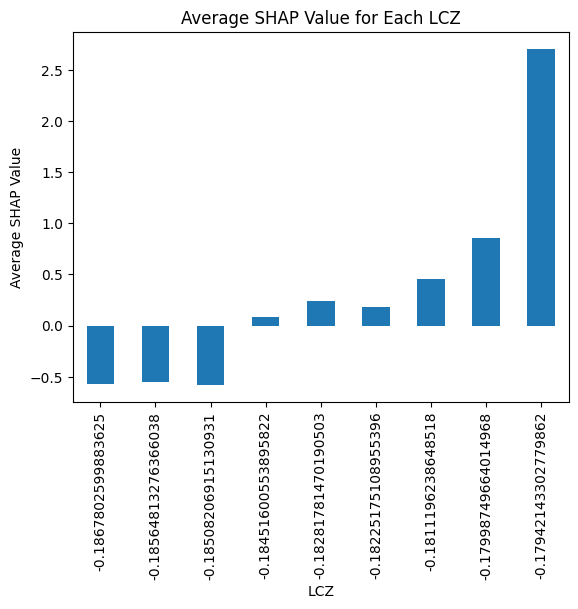

In [53]:
# Visualize the bar plot of average SHAP values for each 'lcz' value
lcz_shap_df = pd.DataFrame({'LCZ': X_test[:, lcz_index], 'SHAP Value': lcz_shap_values})
average_shap_values = lcz_shap_df.groupby('LCZ')['SHAP Value'].mean()
average_shap_values.plot(kind='bar')
plt.xlabel('LCZ')
plt.ylabel('Average SHAP Value')
plt.title('Average SHAP Value for Each LCZ')
plt.show()